In [1]:
import sys
sys.path.append("./../")

import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid

from transformers import BertTokenizer, BertModel

from modules.tadvae_generator.model import Generator
from modules.tadvae_discriminator.model import Discriminator

from config_reader import ConfigReader
from train_utils.utils import zeros_like, ones_like
from train_utils.data_utils import get_cub_dataloaders

In [2]:
def show(img, figsize=(8, 4)):
    plt.figure(figsize=figsize)
    npimg = img.numpy()
    fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.show()

In [3]:
CONFIG = ConfigReader(config_path="/home/andrey/Aalto/thesis/TA-VQVAE/configs/tadvae_cub_local.yaml")
CONFIG.print_config_info()

BATCH_SIZE                              2                                       
DEVICE                                  cpu                                     
LR                                      0.0002                                  
LR_gamma                                0.5                                     
NUM_EPOCHS                              800                                     
config_path                             /home/andrey/Aalto/thesis/TA-VQVAE/configs/tadvae_cub_local.yaml
dvae_model_name                         dvae                                    
img_size                                256                                     
imgs_list_file_path                     /home/andrey/Aalto/thesis/TA-VQVAE/data/CUB/CUB_200_2011/images.txt
lambda_cond_loss                        10                                      
lambda_recon_loss                       1                                       
load_dvae_path                          /home/andrey/Aalto

In [4]:
BERT_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
BERT_model = BertModel.from_pretrained('bert-base-uncased')

G = Generator(
    img_embedding_dim=8192,
    text_embedding_dim=BERT_model.config.hidden_size,
    n_trd_blocks=3,
    num_trd_block_for_mask=2,
    n_attn_heads=4,
    linear_hidden_dim=1024,
    dropout_prob=0.1,
    n_img_hidden_positions=32*32)

D = Discriminator(
    txt_in_dim=BERT_model.config.hidden_size,
    hidden_dim=512)

In [5]:
G.load_dvae_weights(root_path=CONFIG.load_dvae_path, model_name=CONFIG.dvae_model_name)
G.load_rebuild_model(root_path=CONFIG.save_model_path, model_name=CONFIG.save_model_name)


embedding_path = os.path.join(CONFIG.save_model_path, "embedding.pth")
BERT_model.load_state_dict(torch.load(embedding_path, map_location=torch.device('cpu')))

<All keys matched successfully>

In [6]:
G.dvae.eval()
G.text_rebuild_block.eval()
D.eval()
BERT_model.eval()

pass

In [7]:
train_loader, _ = get_cub_dataloaders(tokenizer=BERT_tokenizer,
                                      root_img_path=CONFIG.root_img_path,
                                      root_text_path=CONFIG.root_text_path,
                                      imgs_list_file_path=CONFIG.imgs_list_file_path,
                                      img_size=CONFIG.img_size,
                                      batch_size=CONFIG.BATCH_SIZE)

imgs, (token_tensor, token_type_tensor, mask_tensor, text) = next(iter(train_loader))

In [8]:
text_embeddings = BERT_model(token_tensor, attention_mask=mask_tensor, token_type_ids=token_type_tensor)
text_embeddings = text_embeddings[0]

text_embeddings_neg = torch.cat((text_embeddings[:, -1, :].unsqueeze(1), text_embeddings[:, :-1, :]), 1)
mask_tensor_neg = torch.cat((mask_tensor[-1, :].unsqueeze(0), mask_tensor[:-1, :]), 0)

In [9]:
gen_img, z_mask = G(img=imgs, txt_h=text_embeddings_neg, txt_pad_mask=mask_tensor_neg, return_mask=True)

In [10]:
z_new, z_onehot, z_mask = G.encode(img=imgs, txt_h=text_embeddings_neg, txt_pad_mask=mask_tensor_neg)

In [11]:
text

('this bird has a gray and white side and belly along with some yellow on the side.\n',
 'a bird with iridescent plumage of black, purple and green , a short pointed beak, and a tiny eyering.\n')

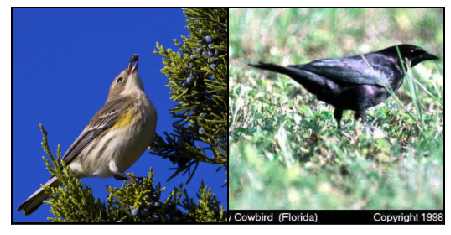

In [12]:
show(make_grid(imgs.data, nrow=2))

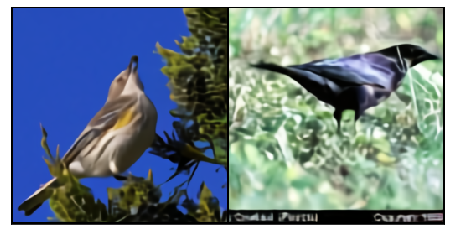

In [13]:
show(make_grid(gen_img.data, nrow=2))

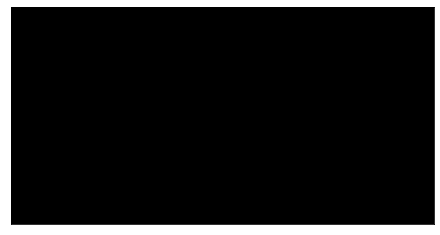

In [14]:
show(make_grid((z_mask*100).data, nrow=2))

In [15]:
np.unique(z_mask.detach().numpy())

array([0.], dtype=float32)